In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as met
from openpyxl import load_workbook
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from data_preprocessing import read_table, merge_str


In [2]:
np.random.seed(0)
random_state = 0

# Binary Prediction of Gentrified Tracts in Melbourne

This notebook was created to test the performance of the baseline model (Logistic Regression) and other off-the-shelf ML models that run with CPU. The training labels were obtained following Freeman's 5-step definition of gentrified areas.

The evaluation process is centered around Recall. In order to do wo while preventing the models from predicting all instances as positive, the main metric is F2 with recall being twice as aimportant as precision.

# Table of Contents

1. [Model Selection](#model_selection) 


&emsp; 1.1. [Models for 2006-2016 Gentrification Period](#2006_2016_model)

&emsp; 1.2. [Models for 2011-2016 Gentrification Period](#2011_2016_model)
   

# Model Selection <a name="model_selection"></a>

In [3]:
def print_metrics(model, y_test, X_test, name='model'):
    print('F2 of ' + name + ' is')
    print(met.fbeta_score(y_test, model.predict(X_test), beta=2))
    print('Recall of ' + name + ' is ')
    print(met.recall_score(y_test, model.predict(X_test)))
    print('Precision of ' + name + ' is ')
    print(met.precision_score(y_test, model.predict(X_test)))
    print('Accuracy of ' + name + ' is ')
    print(met.accuracy_score(y_test, model.predict(X_test)))

In [4]:
def get_important_ft(feature_names, coeficients, number=0):
    if number == 0:
        number = len(feature_names)
    features = {}
    for ft, coef in zip(feature_names,coeficients):
        features[ft] = abs(coef)

    ordered_ft = dict(sorted(features.items(), key=lambda item: item[1], reverse =True))
    
    i = 0
    for ft, coef in ordered_ft.items():
        print(ft)
        print(coef)
        print()
        i = i+1
        if i == number:
            break

In [5]:
def plot_PRC(y_test, y_prob, name='model'):
    precision, recall, thresholds = met.precision_recall_curve(y_test, y_prob)
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==True]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim(0,1)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

##  2006-2016 Gentrification Period <a name='2006_2016_model'></a>

In [6]:
reduced_06_16 = pd.read_csv('Data/dataset_reduced_06_16.csv')
complete_06_16 = pd.read_csv('Data/dataset_complete_06_16.csv')

In [7]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_06R = reduced_06_16.drop(columns = ['SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06R[X_06R.columns] = scaler_R.fit_transform(X_06R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_06C = complete_06_16.drop(columns = ['SA1_MAINCO','Gentrified_06_16'], axis=1)
X_06C[X_06C.columns] = scaler_C.fit_transform(X_06C)

# Split dataset
X_06R_train, X_06R_test, y_06R_train, y_06R_test = train_test_split(X_06R,
                                                                    reduced_06_16['Gentrified_06_16'], 
                                                                    test_size=0.25)

X_06C_train, X_06C_test, y_06C_train, y_06C_test = train_test_split(X_06C,
                                                                    complete_06_16['Gentrified_06_16'], 
                                                                    test_size=0.25)

Logistic Regression with Reduced number of demographic Features

F2 of Logistic Regression is
0.6438541197658713
Recall of Logistic Regression is 
0.8218390804597702
Precision of Logistic Regression is 
0.34499396863691195
Accuracy of Logistic Regression is 
0.7648659152739993


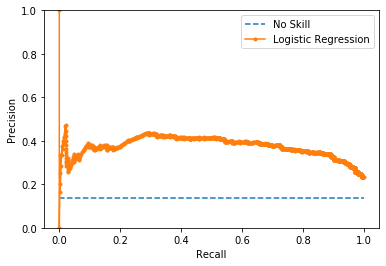

In [8]:
LR_06R = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear',
                           random_state = random_state)
LR_06R.fit(X_06R_train, y_06R_train)

print_metrics(LR_06R, y_06R_test, X_06R_test, name='Logistic Regression')
plot_PRC(y_06R_test,
         LR_06R.predict_proba(X_06R_test)[:, 1],
         name='Logistic Regression')

Logistic Regression with all demographic Features

F2 of Logistic Regression is
0.6346351490236382
Recall of Logistic Regression is 
0.7841269841269841
Precision of Logistic Regression is 
0.36005830903790087
Accuracy of Logistic Regression is 
0.8029537504858142


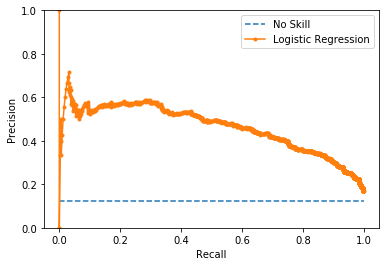

In [9]:
LR_06C = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear')

LR_06C.fit(X_06C_train, y_06C_train)

print_metrics(LR_06C, y_06C_test, X_06C_test, name='Logistic Regression')

plot_PRC(y_06C_test,
         LR_06C.predict_proba(X_06C_test)[:, 1],
         'Logistic Regression')

Random Forest with a reduced number of demographic features:

F2 of Random Forest is
0.5632473253618627
Recall of Random Forest is 
0.514367816091954
Precision of Random Forest is 
0.9086294416243654
Accuracy of Random Forest is 
0.9273221919937816


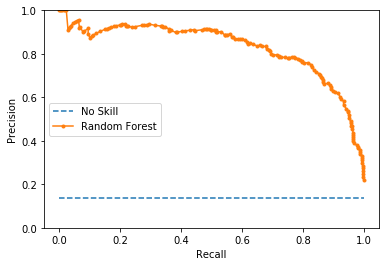

In [10]:
RF_06R = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_06R.fit(X_06R_train, y_06R_train)

print_metrics(RF_06R, y_06R_test, X_06R_test, name='Random Forest')

plot_PRC(y_06R_test,
         RF_06R.predict_proba(X_06R_test)[:, 1],
         'Random Forest')

Random Forest with all of demographic Features

F2 of Random Forest is
0.5440771349862259
Recall of Random Forest is 
0.5015873015873016
Precision of Random Forest is 
0.8229166666666666
Accuracy of Random Forest is 
0.925767586474932


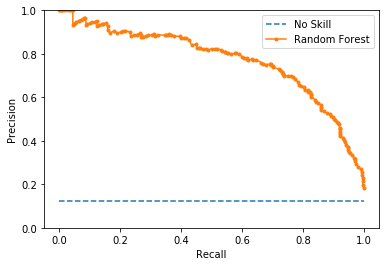

In [11]:
RF_06C = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_06C.fit(X_06C_train, y_06C_train)

print_metrics(RF_06C, y_06C_test, X_06C_test, name='Random Forest')

plot_PRC(y_06C_test,
         RF_06C.predict_proba(X_06C_test)[:, 1],
         'Random Forest')

SVM with a reduced number of demographic features

In [12]:
SVM_06_R = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_06_R.fit(X_06R_train, y_06R_train)
print_metrics(SVM_06_R, y_06R_test, X_06R_test, name='SVM')

F2 of SVM is
0.6571428571428571
Recall of SVM is 
0.8591954022988506
Precision of SVM is 
0.33861834654586637
Accuracy of SVM is 
0.7539836766420521


Naive Bayes with all of demographic features

In [13]:
SVM_06_C = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_06_C.fit(X_06C_train, y_06C_train)
print_metrics(SVM_06_C, y_06C_test, X_06C_test, name='SVM')

F2 of SVM is
0.6586224233283057
Recall of SVM is 
0.8317460317460318
Precision of SVM is 
0.35939643347050754
Accuracy of SVM is 
0.7979012825495531


Naive bayes with a reduced number of demographic features

F2 of Naive Bayes is
0.5437956204379563
Recall of Naive Bayes is 
0.8563218390804598
Precision of Naive Bayes is 
0.22106824925816024
Accuracy of Naive Bayes is 
0.5724834823163623


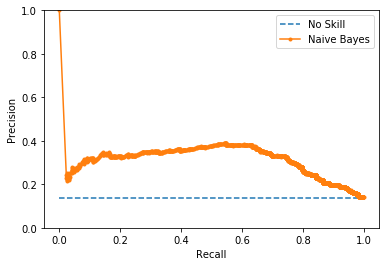

In [14]:
NB_06_R = GaussianNB()
NB_06_R.fit(X_06R_train, y_06R_train)

print_metrics(NB_06_R, y_06R_test, X_06R_test, name='Naive Bayes')

plot_PRC(y_06R_test,
         NB_06_R.predict_proba(X_06R_test)[:, 1],
         'Naive Bayes')

Naive Bayes with all of demographic features

F2 of Naive Bayes is
0.4821802935010483
Recall of Naive Bayes is 
0.8761904761904762
Precision of Naive Bayes is 
0.17228464419475656
Accuracy of Naive Bayes is 
0.4694908666925768


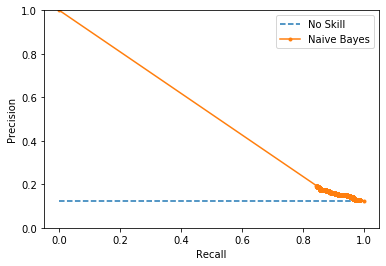

In [15]:
NB_06_C = GaussianNB()
NB_06_C.fit(X_06C_train, y_06C_train)

print_metrics(NB_06_C, y_06C_test, X_06C_test, name='Naive Bayes')

plot_PRC(y_06C_test,
         NB_06_C.predict_proba(X_06C_test)[:, 1],
         'Naive Bayes')

In the context of gentrification between 2006 and 2016 the baseline (Logistic Regresion) is the second best performing model, only after the SVM with a marignial improvement of 0.01. Both models perform better with the dataser reduced in demographic features. 

##  20011-2016 Gentrification Period <a name='2011_2016_model'></a>

In [16]:
reduced_11_16 = pd.read_csv('Data/dataset_reduced_11_16.csv')
complete_11_16 = pd.read_csv('Data/dataset_complete_11_16.csv')

In [17]:
# Normalize dataset
scaler_R = preprocessing.MinMaxScaler()
X_11R = reduced_11_16.drop(columns = ['SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11R[X_11R.columns] = scaler_R.fit_transform(X_11R)
                                               
scaler_C = preprocessing.MinMaxScaler()
X_11C = complete_11_16.drop(columns = ['SA1_MAINCO','Gentrified_11_16'], axis=1)
X_11C[X_11C.columns] = scaler_C.fit_transform(X_11C)

# Split dataset
X_11R_train, X_11R_test, y_11R_train, y_11R_test = train_test_split(X_11R,
                                                                    reduced_11_16['Gentrified_11_16'], 
                                                                    test_size=0.25)

X_11C_train, X_11C_test, y_11C_train, y_11C_test = train_test_split(X_11C,
                                                                    complete_11_16['Gentrified_11_16'], 
                                                                    test_size=0.25)

Logistic Regression with a reduced number of demographic features

F2 of Logistic Regression is
0.5674300254452928
Recall of Logistic Regression is 
0.7797202797202797
Precision of Logistic Regression is 
0.27161997563946405
Accuracy of Logistic Regression is 
0.743101438010105


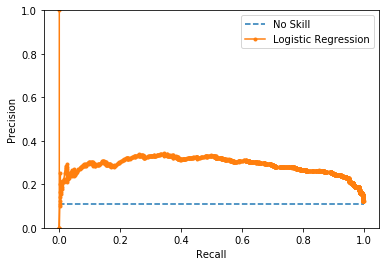

In [18]:
LR_11R = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear',
                           random_state = random_state)
LR_11R.fit(X_11R_train, y_11R_train)

print_metrics(LR_11R, y_11R_test, X_11R_test, name='Logistic Regression')
plot_PRC(y_11R_test,
         LR_11R.predict_proba(X_11R_test)[:, 1],
         name='Logistic Regression')

Logistic Regression with all demographic features

F2 of Logistic Regression is
0.5364693446088795
Recall of Logistic Regression is 
0.7198581560283688
Precision of Logistic Regression is 
0.26570680628272253
Accuracy of Logistic Regression is 
0.7512631169840653


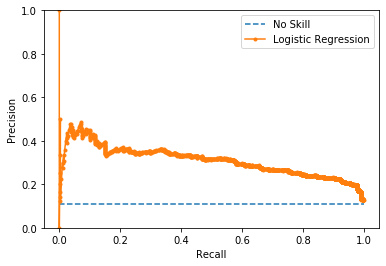

In [19]:
LR_11C = LogisticRegression(class_weight='balanced',
                           penalty = 'l1',
                           solver='liblinear')

LR_11C.fit(X_11C_train, y_11C_train)

print_metrics(LR_11C, y_11C_test, X_11C_test, name='Logistic Regression')

plot_PRC(y_11C_test,
         LR_11C.predict_proba(X_11C_test)[:, 1],
         'Logistic Regression')

Random Forest with a reduced number of demographic features

F2 of Random Forest is
0.24350649350649353
Recall of Random Forest is 
0.2097902097902098
Precision of Random Forest is 
0.6818181818181818
Accuracy of Random Forest is 
0.9012825495530509


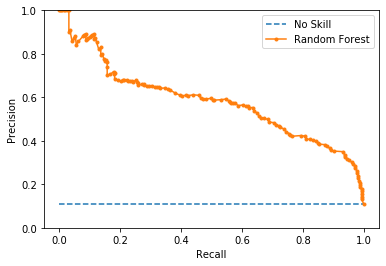

In [20]:
RF_11R = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_11R.fit(X_11R_train, y_11R_train)

print_metrics(RF_11R, y_11R_test, X_11R_test, name='Random Forest')

plot_PRC(y_11R_test,
         RF_11R.predict_proba(X_11R_test)[:, 1],
         'Random Forest')

Random Forest with all demographic features

F2 of Random Forest is
0.15151515151515152
Recall of Random Forest is 
0.1276595744680851
Precision of Random Forest is 
0.6
Accuracy of Random Forest is 
0.8950641274776525


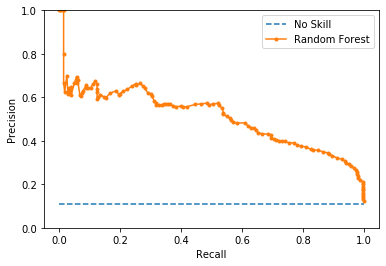

In [21]:
RF_11C = RandomForestClassifier(n_estimators=200,
                                criterion='gini',
                                max_features=0.6,
                                class_weight='balanced_subsample',
                                random_state=random_state
                                )
RF_11C.fit(X_11C_train, y_11C_train)

print_metrics(RF_11C, y_11C_test, X_11C_test, name='Random Forest')

plot_PRC(y_11C_test,
         RF_11C.predict_proba(X_11C_test)[:, 1],
         'Random Forest')

SVM with a reduced number of demographic features

In [22]:
SVM_11_R = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_11_R.fit(X_11R_train, y_11R_train)
print_metrics(SVM_11_R, y_11R_test, X_11R_test, name='SVM')

F2 of SVM is
0.5800970873786407
Recall of SVM is 
0.8356643356643356
Precision of SVM is 
0.2609170305676856
Accuracy of SVM is 
0.7186164010882239


SVM with all the demographic features

In [23]:
SVM_11_C = SVC(kernel='linear',
              class_weight= 'balanced')
SVM_11_C.fit(X_11C_train, y_11C_train)
print_metrics(SVM_11_C, y_11C_test, X_11C_test, name='SVM')

F2 of SVM is
0.536547433903577
Recall of SVM is 
0.7340425531914894
Precision of SVM is 
0.25842696629213485
Accuracy of SVM is 
0.7399922269724057


Naive Bayes with a reduced number of demographic features

F2 of Naive Bayes is
0.4334314687602225
Recall of Naive Bayes is 
0.9265734265734266
Precision of Naive Bayes is 
0.13852587558808155
Accuracy of Naive Bayes is 
0.35134084726000775


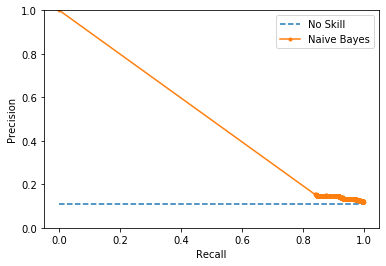

In [24]:
NB_11_R = GaussianNB()
NB_11_R.fit(X_11R_train, y_11R_train)

print_metrics(NB_11_R, y_11R_test, X_11R_test, name='Naive Bayes')

plot_PRC(y_11R_test,
         NB_11_R.predict_proba(X_11R_test)[:, 1],
         'Naive Bayes')

Naive Bayes with all the demographic features

F2 of Naive Bayes is
0.4271665642286417
Recall of Naive Bayes is 
0.9858156028368794
Precision of Naive Bayes is 
0.13076199435559738
Accuracy of Naive Bayes is 
0.28021764477263894


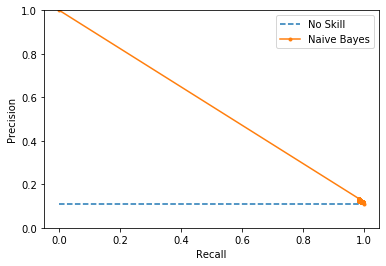

In [25]:
NB_11_C = GaussianNB()
NB_11_C.fit(X_11C_train, y_11C_train)

print_metrics(NB_11_C, y_11C_test, X_11C_test, name='Naive Bayes')

plot_PRC(y_11C_test,
         NB_11_C.predict_proba(X_11C_test)[:, 1],
         'Naive Bayes')

Overall, the models trained with data from a 5-year period of gentrification (2011-2016) have a lower performacne than thoe trained with the 10-year gentrification period. But both groups of models perform best -generally speaking- with a reduced number of demographic features. SVM and Logistic Regression are the best performing models in this experiement as well.